## Neural Style Transfer 
## DD2424 Project based on : 'A Neural Algorithm of Artistic Style' Leon A. Gatys,Alexander S. Ecker,Matthias Bethge


### Import packages and libraries

In [1]:
import os 
import tensorflow as tf
from keras.applications.vgg19 import VGG19
from keras.applications.vgg19 import preprocess_input
from keras.preprocessing.image import load_img, img_to_array
from keras.models import Model

import IPython.display as display
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import PIL.Image
import time
import functools

## Functions

In [27]:
#Load images and preprocess them to the correct shape
def loadImg(path): 
  x = load_img(path, target_size= (224, 224))
  x = img_to_array(x)
  x = np.expand_dims(x, axis=0)
  preprocess_input(x)

  x = (x + 127.5)/255
  
  return x

def imShow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)
  plt.imshow(image)
  
  if title:
    plt.title(title)

def vgg_model(layers): 
    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False
    outputs = [vgg.get_layer(name).output for name in layers]
    model = tf.keras.Model([vgg.input], outputs)
    return model

def gram_matrix(F):
  G = np.matmul(np.transpose(F), F)
  return G


## Prepare the model VGG19

In [3]:
#Following the method of the paper : we first import the VGG19-Network. The
#feature space provided by the 16 convolutional and 5 pooling layers of the 19 #layer VGGNetwork

VGG19 = tf.keras.applications.VGG19(include_top=False)

content_layers = ['block5_conv2'] 
style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1','block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

## Extract features from content and style image

57344/51025 [=================================] - 0s 2us/step
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Content features Size : 
(1, 14, 14, 512)
Style features Size : 
(1, 224, 224, 64)
(1, 112, 112, 128)
(1, 56, 56, 256)
(1, 28, 28, 512)
(1, 14, 14, 512)


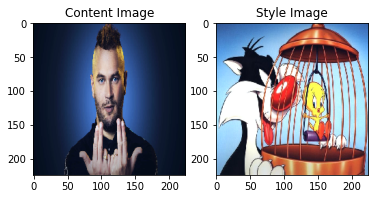

In [14]:
#Get the path of the pictures we want
content_path = tf.keras.utils.get_file('jul.jpg', 'https://img.lemde.fr/2020/11/18/494/0/8688/4340/1440/720/60/0/7d2c869_856070765-jul-fifou-0888.jpg')
style_path = tf.keras.utils.get_file('titiandgros.jpg', 'https://i.pinimg.com/564x/99/d3/21/99d321028e0803f9c928aadc78f934f8.jpg')

#Load them
content_img = loadImg(content_path)
style_img = loadImg(style_path)

plt.subplot(1,2,1)
imShow(content_img, 'Content Image')
plt.subplot(1,2,2)
imShow(style_img, 'Style Image')

content_model = vgg_model(content_layers)
style_model = vgg_model(style_layers)

#Create the features map of both images
content_features = content_model.predict(content_img)
style_features = style_model.predict(style_img)

#Print shapes to debug
print ("Content features Size : ")
print(content_features.shape)
print('Style features Size : ')
for i in range(len(style_features)):
    print(style_features[i].shape)

## Extract features from the white noise image

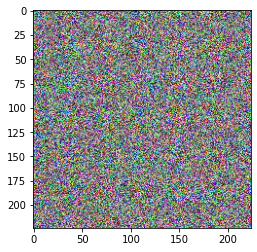

In [28]:
noisy_image = np.random.uniform(0, 1, [1,224, 224, 3])
imShow(noisy_image)

#Create the features map of both images
noise_content_features = content_model.predict(noisy_image)
noise_style_features = style_model.predict(noisy_image)
'''
Content features Size : 
(1, 14, 14, 512)
Style features Size : 
(1, 224, 224, 64)
(1, 112, 112, 128)
(1, 56, 56, 256)
(1, 28, 28, 512)
(1, 14, 14, 512)

'''
#Compute Gram matrices for style
G = []
A = []
# First reshape features in MlxNl
for layer in range(len(noise_style_features)):
    Ml = noise_style_features[layer].shape[1]*noise_style_features[layer].shape[2]
    Nl = noise_style_features[layer].shape[3]

    Fl = np.reshape(noise_style_features[layer],(Ml, Nl))
    G.append(gram_matrix(Fl))

    Al = np.reshape(style_features[layer],(Ml, Nl))
    A.append(gram_matrix(Al))


In [30]:
G[0].shape

(64, 64)

## Compare 